In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# load data 
climbing = pd.read_csv("./climbing_dataset/climber_df.csv")
climbing.head()
# 10927 rows x 16 columns
# 26 countries, most European
# 0=male, 1=female
# mean age 33 years, 12 min, 69 max

,user_id,country,sex,height,weight,age,years_cl,date_first,date_last,grades_count,grades_first,grades_last,grades_max,grades_mean,year_first,year_last
0,1,SWE,0,177,73,41.0,21,1999-02-06 23:00:00,2001-07-31 22:00:00,84,36,55,62,46.750000,1999,2001
1,3,SWE,0,180,78,44.0,22,1999-03-31 22:00:00,2000-07-19 22:00:00,12,53,51,59,52.833333,1999,2000
2,4,SWE,1,165,58,33.0,16,2004-06-30 22:00:00,2009-05-26 22:00:00,119,53,49,64,53.890756,2004,2009
3,10,SWE,0,167,63,52.0,25,2000-01-14 23:00:00,2017-06-01 22:00:00,298,53,49,63,49.406040,2000,2017
4,16,NOR,0,177,68,44.0,21,1998-02-27 23:00:00,2010-05-13 22:00:00,5,53,49,53,51.400000,1998,2010


In [3]:
# which target we will try to predict
target = 'grades_max'

In [4]:
# print descriptives
climbing.describe()

,user_id,sex,height,weight,age,years_cl,grades_count,grades_first,grades_last,grades_max,grades_mean,year_first,year_last
count,10927.00000,10927.000000,10927.000000,10927.000000,10927.000000,10927.000000,10927.000000,10927.000000,10927.000000,10927.000000,10927.000000,10927.000000,10927.000000
mean,29411.09774,0.125103,176.152009,67.608676,33.333852,12.672188,79.794546,45.648851,46.983802,53.764437,45.505055,2008.621946,2012.311613
std,18022.12695,0.330851,8.508669,9.677316,7.590989,6.108451,141.411297,9.478173,9.418087,9.679533,7.891356,28.833298,4.161484
min,1.00000,0.000000,137.000000,40.000000,12.000000,1.000000,1.000000,28.000000,28.000000,29.000000,28.500000,0.000000,1991.000000
25%,14651.00000,0.000000,171.000000,63.000000,28.000000,8.000000,8.000000,38.000000,40.000000,46.000000,39.400000,2006.000000,2009.000000
50%,27323.00000,0.000000,177.000000,68.000000,33.000000,12.000000,28.000000,46.000000,48.000000,55.000000,45.151899,2009.000000,2013.000000
75%,43240.50000,0.000000,182.000000,73.000000,38.000000,17.000000,90.000000,53.000000,53.000000,62.000000,51.210084,2012.000000,2016.000000
max,67020.00000,1.000000,202.000000,93.000000,69.000000,29.000000,2445.000000,75.000000,77.000000,77.000000,75.272727,2017.000000,2017.000000


In [5]:
len(climbing['country'].unique())

26

In [6]:
# first pass: frist drop country and date first and last and predict grades max
X = climbing.drop(['user_id','grades_count','grades_first','grades_last','grades_max','grades_mean','date_first','date_last'],axis=1)

# one hot encode country
one_hot_encoded = pd.get_dummies(X['country'])

# Concatenate the one-hot encoded columns with the original DataFrame
X_encoded = pd.concat([X, one_hot_encoded], axis=1)

# remove original country column
X_encoded.drop(labels='country',axis=1, inplace=True)

X_encoded.head()

,sex,height,weight,age,years_cl,year_first,year_last,AUS,AUT,BEL,...,NLD,NOR,POL,PRT,RUS,SVN,SWE,USA,ZAF,other
0,0,177,73,41.0,21,1999,2001,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,180,78,44.0,22,1999,2000,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,1,165,58,33.0,16,2004,2009,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,167,63,52.0,25,2000,2017,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,177,68,44.0,21,1998,2010,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [7]:
# feature engineering: compute BMI
X_encoded['BMI'] = X_encoded['weight'] / (X_encoded['height']/100)**2

In [8]:
X_encoded.columns

Index(['sex', 'height', 'weight', 'age', 'years_cl', 'year_first', 'year_last',
       'AUS', 'AUT', 'BEL', 'BRA', 'CAN', 'CHE', 'CZE', 'DEU', 'DNK', 'ESP',
       'FIN', 'FRA', 'GBR', 'HRV', 'ITA', 'MEX', 'NLD', 'NOR', 'POL', 'PRT',
       'RUS', 'SVN', 'SWE', 'USA', 'ZAF', 'other', 'BMI'],
      dtype='object')

In [9]:
# define y: highest grade climbed
y = climbing[target]

In [10]:
# make predictions
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Create a Linear Regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

In [11]:
# evaluate predictions
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate mean squared error
mse = mean_squared_error(y_test, y_pred)

# Calculate root mean squared error
rmse = np.sqrt(mse)

print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 7.387431304837275


In [12]:
# asses scale of target variable
print(f'The grades vary between {y.min()} and {y.max()} units')

The grades vary between 29 and 77 units


In [13]:
# find out which features contribute most to the prediction by getting the coefficients

# Get the feature coefficients
feature_coefs = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': model.coef_})

# Sort the coefficients by magnitude
feature_coefs = feature_coefs.reindex(feature_coefs['Coefficient'].sort_values(ascending=False).index)

# Print the feature coefficients
print(feature_coefs)

       Feature  Coefficient
13         CZE     2.616239
28         SVN     1.692186
22         MEX     1.600124
7          AUS     1.284949
32       other     1.115240
8          AUT     1.103179
27         RUS     1.058609
6    year_last     1.007914
18         FRA     0.998143
4     years_cl     0.959809
14         DEU     0.825983
12         CHE     0.605424
11         CAN     0.600122
19         GBR     0.557968
33         BMI     0.496504
30         USA     0.290695
21         ITA     0.286978
24         NOR     0.235565
1       height     0.221024
5   year_first    -0.009796
16         ESP    -0.131876
3          age    -0.292787
9          BEL    -0.332795
2       weight    -0.409317
25         POL    -0.471867
10         BRA    -0.585799
15         DNK    -0.650321
23         NLD    -1.043305
20         HRV    -1.286211
29         SWE    -1.732794
17         FIN    -2.603717
31         ZAF    -2.871755
26         PRT    -3.160964
0          sex    -4.833409


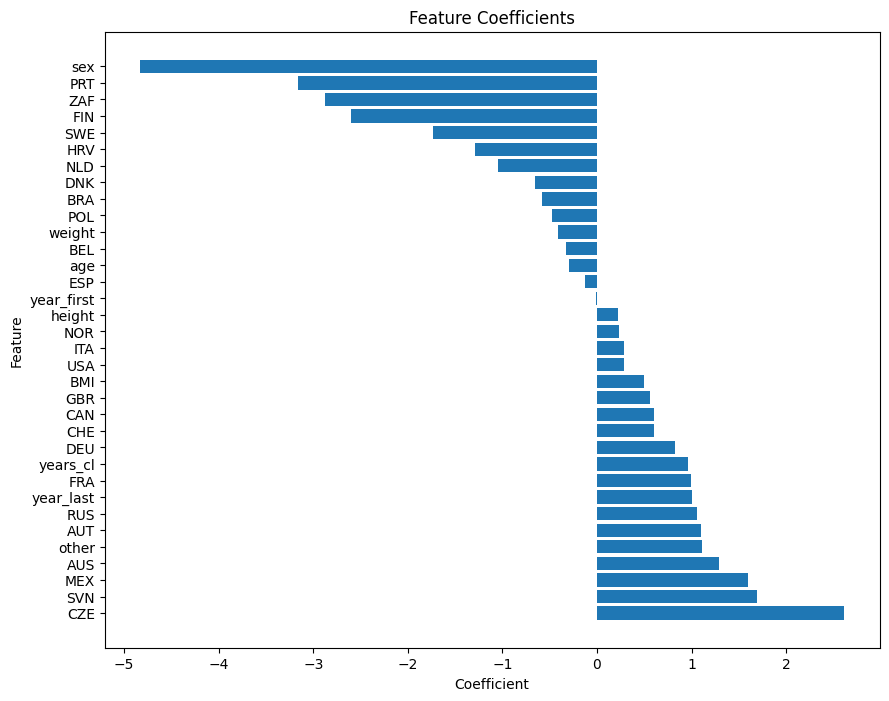

In [14]:
import matplotlib.pyplot as plt

# Plot the feature coefficients
plt.figure(figsize=(10, 8))
plt.barh(feature_coefs['Feature'], feature_coefs['Coefficient'])
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Feature Coefficients')
plt.show()

In [15]:
# make a prediction for a new row/person

# Create a new row with feature values for prediction
new_climber = pd.DataFrame({
                        'sex': [1], 'height': [167], 'weight': [52], 'age': [33], 'years_cl': [4],
       'year_first': [2019], 'year_last': [2023], 'country': 'DEU'
})


In [16]:
# create 1-hot encoding for country 

# make dictionary of 0's for each country
encoded_dict = dict(zip(climbing['country'].unique(), np.zeros(26)))

# insert 1 at new climber's country
encoded_dict[new_climber['country'][0]] = 1

# turn into df
new_encoded = pd.DataFrame(encoded_dict, index=[0])

# add new columns to new climber's DF
new_climber = pd.concat([new_climber, new_encoded], axis=1)

# remove country again
new_climber.drop('country',axis=1, inplace=True)

In [17]:
# calculate BMI for new climber
new_climber['BMI'] = new_climber['weight'] / (new_climber['height']/100)**2
new_climber.head()

,sex,height,weight,age,years_cl,year_first,year_last,SWE,NOR,BEL,...,ESP,HRV,MEX,BRA,CHE,SVN,DNK,RUS,FIN,BMI
0,1,167,52,33,4,2019,2023,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.645344


In [18]:
# Make prediction for the new row
prediction = model.predict(new_climber)

print("Prediction:", prediction)

Prediction: [54.10824995]


/Users/monika/opt/anaconda3/envs/dsr-b34/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [19]:
# convert to French scale and output result
conversion_table = pd.read_csv("./climbing_dataset/grades_conversion_table.csv")
conversion_table.head()

,Unnamed: 0,grade_id,grade_fra
0,0,0,-
1,1,1,-
2,2,2,-
3,3,3,1
4,4,4,1a


In [20]:
my_grade  = int(np.rint(prediction))
row_index = conversion_table.loc[conversion_table['grade_id'] == my_grade].index[0]
french_grade = conversion_table.loc[row_index,'grade_fra']
print(f'Your predicted grade is {french_grade}')

Your predicted grade is 7b/+
